In [1]:
!pip install mat73
import numpy as np
import matplotlib.pyplot as plt
import cv2
import mat73

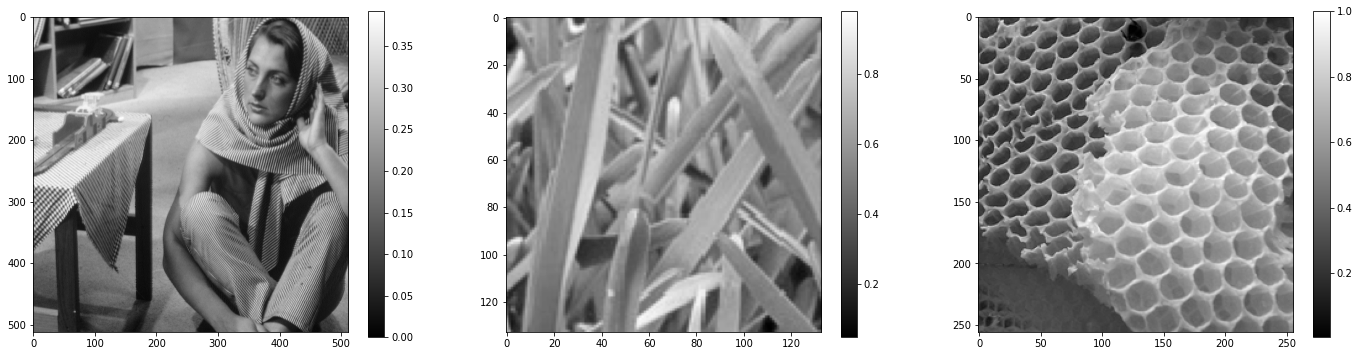

In [2]:
barbara = mat73.loadmat('../data/barbara.mat')['imageOrig']/255.0
data_2 = cv2.imread('../data/grass.png')
data_3 = cv2.imread('../data/honeyCombReal.png')
grass = cv2.cvtColor(data_2, cv2.COLOR_BGR2GRAY)/255.0
honey = cv2.cvtColor(data_3, cv2.COLOR_BGR2GRAY)/255.0
plt.figure(figsize=(24,6))
plt.subplot(131)
plt.imshow(barbara, cmap='gray')
plt.colorbar()
plt.subplot(132)
plt.imshow(grass, cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(honey, cmap='gray')
plt.colorbar()

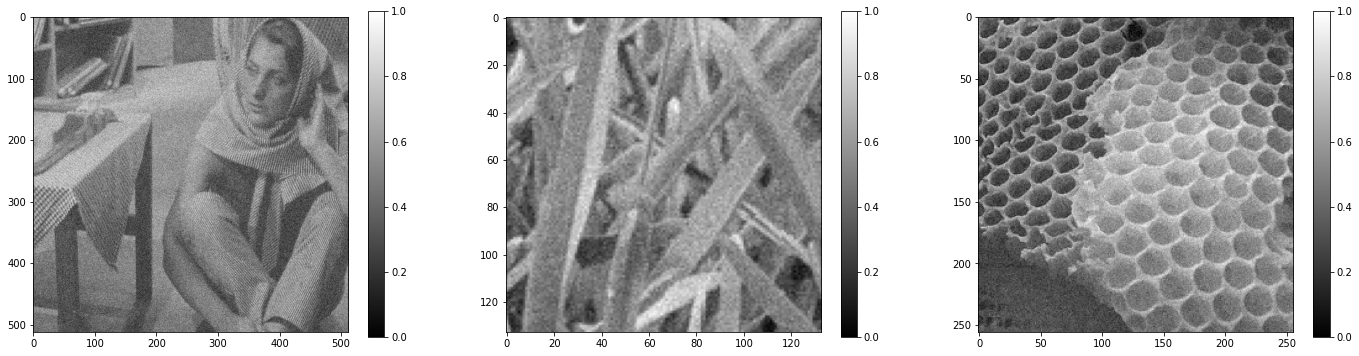

In [3]:
def myGaussianNoise(image,sd):
  noise = np.random.normal(0,sd,image.shape)
  noisy_image = image + noise
  noisy_image = (noisy_image-np.min(noisy_image))/(np.max(noisy_image)-np.min(noisy_image))
  return noisy_image
corrupted_barbara = myGaussianNoise(barbara,0.05)
corrupted_grass = myGaussianNoise(grass,0.05)
corrupted_honey = myGaussianNoise(honey,0.05)
plt.figure(figsize=(24,6))
plt.subplot(131)
plt.imshow(corrupted_barbara, cmap='gray')
plt.colorbar()
plt.subplot(132)
plt.imshow(corrupted_grass, cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(corrupted_honey, cmap='gray')
plt.colorbar()

In [4]:
def myLinearContrastStretching(img):
    low = np.min(img)
    high = np.max(img)
    new_img = (img-low)/(high-low)
    return new_img

def rmsd(img1,img2):
  return np.linalg.norm(img1-img2)/(img1.shape[0])

def myBilateralFiltering(img,sigma_d,sigma_I):
    f_dim = 7  # dimension of filter
    img = np.pad(img, pad_width=f_dim//2, mode='constant', constant_values=0)
    l, w = img.shape
    # coefficients due to euclidian distance (7 x 7 neighbour)
    x_, y_ = np.meshgrid(np.linspace(-1,1,f_dim), np.linspace(-1,1,f_dim))
    d = np.sqrt(x_*x_+y_*y_)
    mu_d = 0.0  # space parameters
    mu_I = 0.0  # intensity parameters
    gauss_sp = np.exp(-((d-mu_d)**2 / (2.0*sigma_d**2))) # gaussian distribution

    # convolving with the filter
    pad = f_dim//2
    output = np.zeros((l-2*pad, w-2*pad), dtype="float32")
    for y in np.arange(pad, l - pad):
        for x in np.arange(pad, w - pad):
            # region of interest from the input image in each iteration
            roi = img[y - pad:y + pad + 1, x - pad:x + pad + 1]
            # intensity difference with this pixel's in the region (7 x 7 neighbour)
            ints = roi - img[y][x]
            # point by point multiplication of space coefficients with intensity
            # coefficients after computing later from the gaussian distribution
            gauss_ints = np.exp(-((ints-mu_I)**2 / (2.0*sigma_I**2))) * gauss_sp
            # result gauss_ints corresponds to the bilateral filter coefficients
            # multiply the filter values pointwise in region of interest and add
            mul = (roi * gauss_ints).sum()
            output[y - pad, x - pad] = mul

    return myLinearContrastStretching(output) # float [0, 1]

RMSD (optimal) : 0.29885509610176086 0.043172646868005184 0.043315558725546315


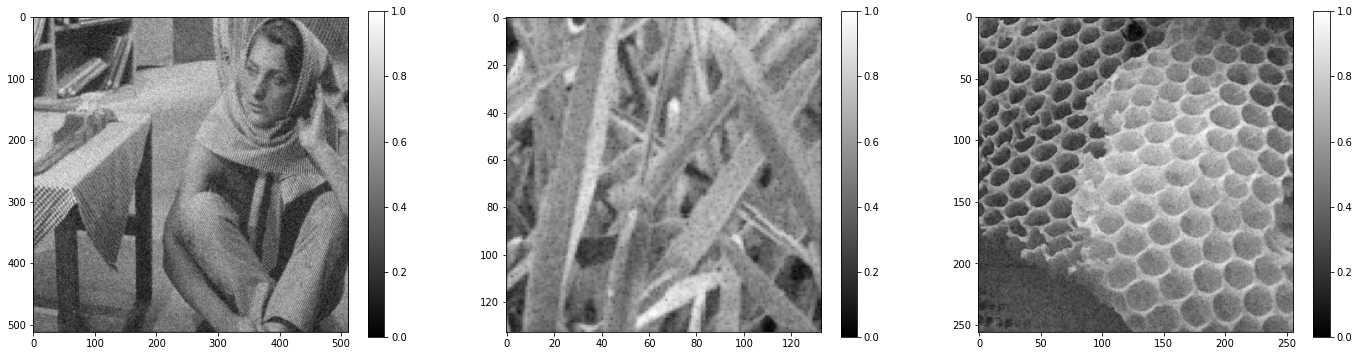

In [122]:
sigma_d1 = 0.186
sigma_i1 = 40
sigma_d2 = 0.162
sigma_i2 = 0.178
sigma_d3 = 0.155
sigma_i3 = 0.203
recovered_barbara = myBilateralFiltering(corrupted_barbara,sigma_d1,sigma_i1)
recovered_grass = myBilateralFiltering(corrupted_grass,sigma_d2,sigma_i2)
recovered_honey = myBilateralFiltering(corrupted_honey,sigma_d3,sigma_i3)
print("RMSD (optimal) :",rmsd(barbara,recovered_barbara),rmsd(grass,recovered_grass),rmsd(honey,recovered_honey))
plt.figure(figsize=(24,6))
plt.subplot(131)
plt.imshow(recovered_barbara, cmap='gray')
plt.colorbar()
plt.subplot(132)
plt.imshow(recovered_grass, cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(recovered_honey, cmap='gray')
plt.colorbar()

sigma_d for barbara = 0.186

sigma_i for barbara = 40(it goes on decreasing as this is increased) 

sigma_d for grass = 0.162

sigma_i for grass = 0.178 

sigma_d for honey = 0.155

sigma_i for honey = 0.203  (optimal values)

Changes when gaussian noise is Changed



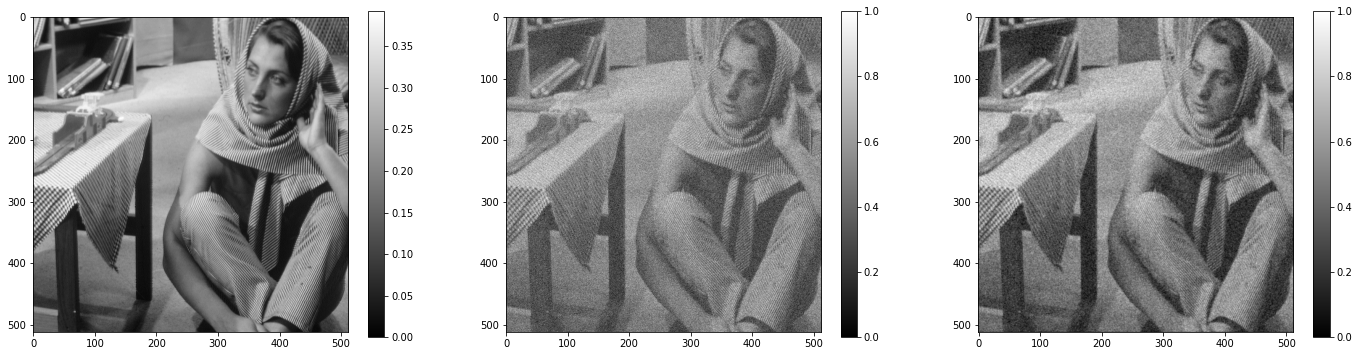

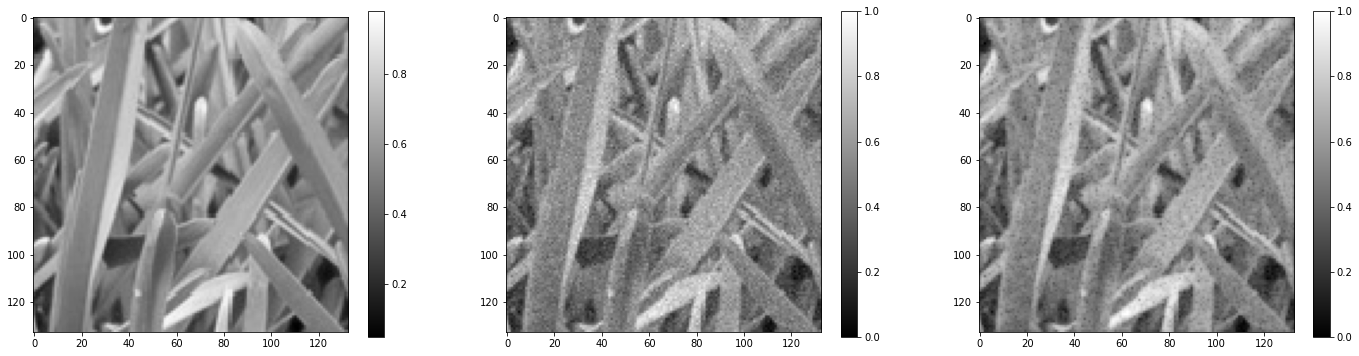

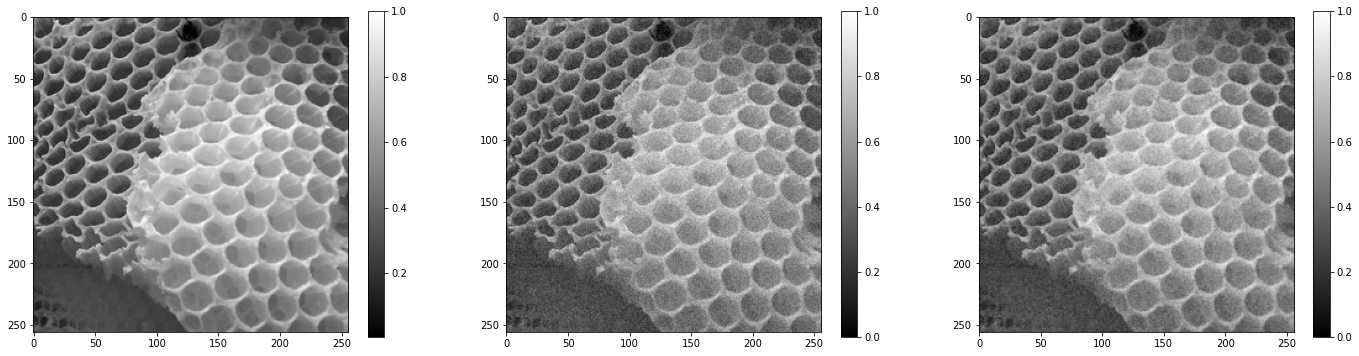

In [123]:
plt.figure(figsize=(24,6))
plt.subplot(131)
plt.imshow(barbara, cmap='gray')
plt.colorbar()
plt.subplot(132)
plt.imshow(corrupted_barbara, cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(recovered_barbara, cmap='gray')
plt.colorbar()

plt.figure(figsize=(24,6))
plt.subplot(131)
plt.imshow(grass, cmap='gray')
plt.colorbar()
plt.subplot(132)
plt.imshow(corrupted_grass, cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(recovered_grass, cmap='gray')
plt.colorbar()

plt.figure(figsize=(24,6))
plt.subplot(131)
plt.imshow(honey, cmap='gray')
plt.colorbar()
plt.subplot(132)
plt.imshow(corrupted_honey, cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(recovered_honey, cmap='gray')
plt.colorbar()

Below is the spatial Gaussian filter for three images side by side(barbara,grass,honey)

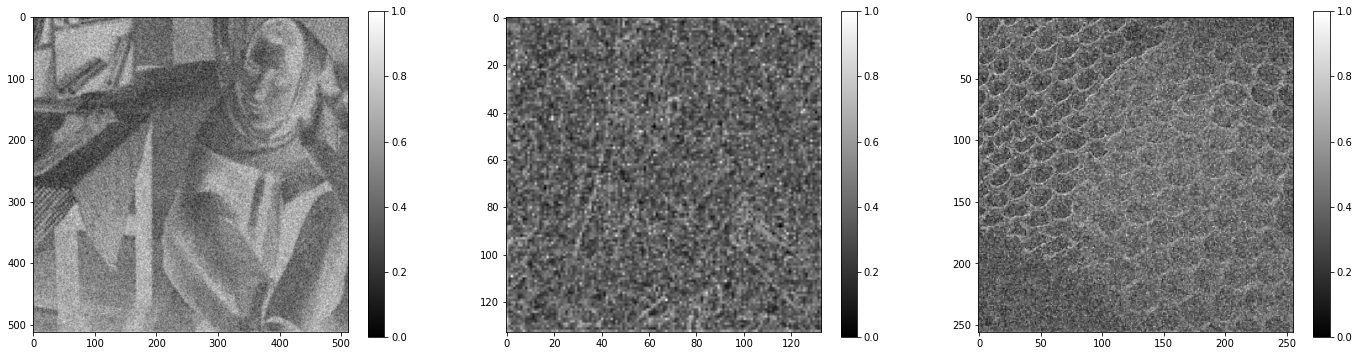

In [124]:
plt.figure(figsize=(24,6))
plt.subplot(131)
plt.imshow(myLinearContrastStretching(barbara - recovered_barbara), cmap='gray')
plt.colorbar()
plt.subplot(132)
plt.imshow(myLinearContrastStretching(grass - recovered_grass), cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(myLinearContrastStretching(honey - recovered_honey), cmap='gray')
plt.colorbar()

RMSD : 0.3038029968738556 0.04490711794306241 0.04426024259941336


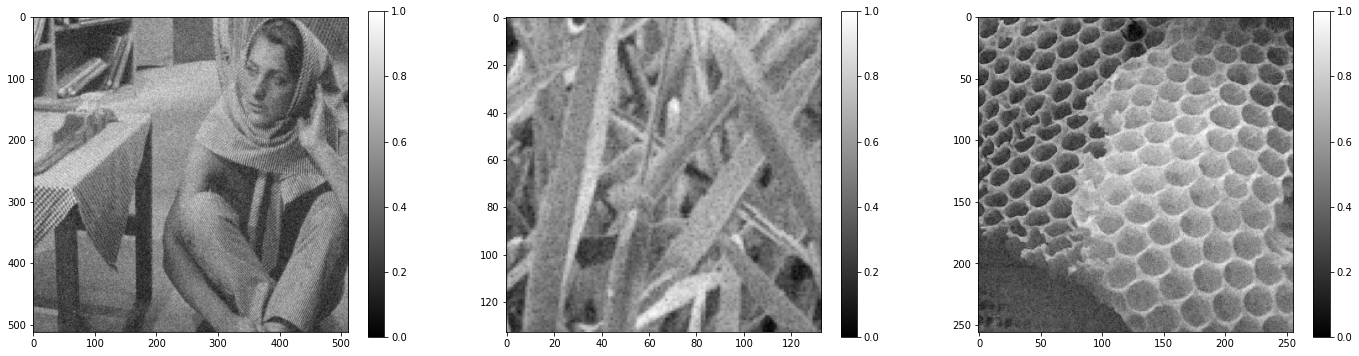

In [125]:
c_d = 0.9
c_i = 1
recovered_barbara = myBilateralFiltering(corrupted_barbara,c_d*sigma_d1,c_i*sigma_i1)
recovered_grass = myBilateralFiltering(corrupted_grass,c_d*sigma_d2,c_i*sigma_i2)
recovered_honey = myBilateralFiltering(corrupted_honey,c_d*sigma_d3,c_i*sigma_i3)
print("RMSD :",rmsd(barbara,recovered_barbara),rmsd(grass,recovered_grass),rmsd(honey,recovered_honey))
plt.figure(figsize=(24,6))
plt.subplot(131)
plt.imshow(recovered_barbara, cmap='gray')
plt.colorbar()
plt.subplot(132)
plt.imshow(recovered_grass, cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(recovered_honey, cmap='gray')
plt.colorbar()

RMSD : 0.3058362603187561 0.045924751394482634 0.04514324202946615


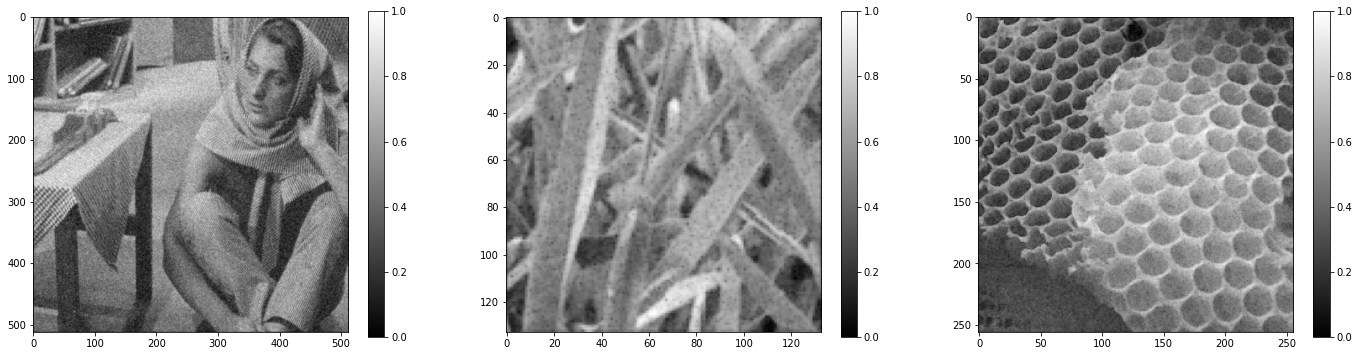

In [126]:
c_d = 1.1
c_i = 1
recovered_barbara = myBilateralFiltering(corrupted_barbara,c_d*sigma_d1,c_i*sigma_i1)
recovered_grass = myBilateralFiltering(corrupted_grass,c_d*sigma_d2,c_i*sigma_i2)
recovered_honey = myBilateralFiltering(corrupted_honey,c_d*sigma_d3,c_i*sigma_i3)
print("RMSD :",rmsd(barbara,recovered_barbara),rmsd(grass,recovered_grass),rmsd(honey,recovered_honey))
plt.figure(figsize=(24,6))
plt.subplot(131)
plt.imshow(recovered_barbara, cmap='gray')
plt.colorbar()
plt.subplot(132)
plt.imshow(recovered_grass, cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(recovered_honey, cmap='gray')
plt.colorbar()

RMSD : 0.29885661602020264 0.0442383764546124 0.04449882735135764


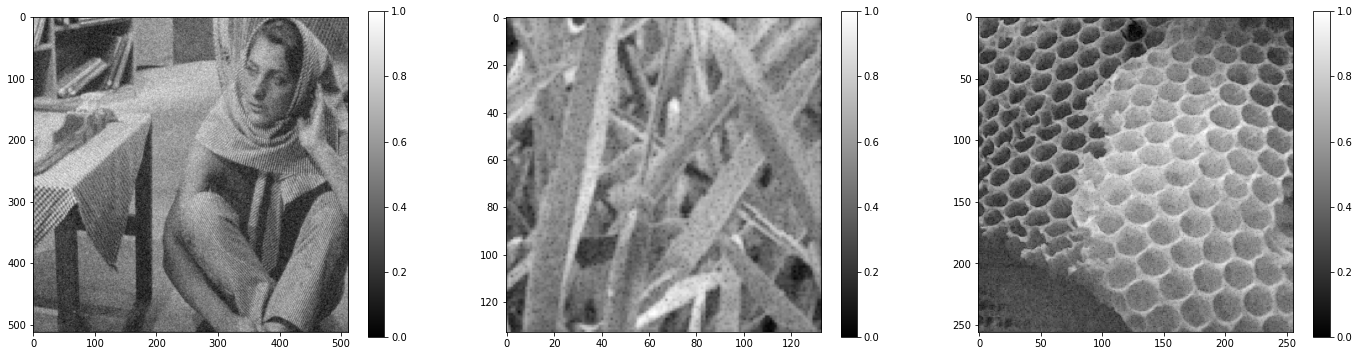

In [127]:
c_d = 1
c_i = 0.9
recovered_barbara = myBilateralFiltering(corrupted_barbara,c_d*sigma_d1,c_i*sigma_i1)
recovered_grass = myBilateralFiltering(corrupted_grass,c_d*sigma_d2,c_i*sigma_i2)
recovered_honey = myBilateralFiltering(corrupted_honey,c_d*sigma_d3,c_i*sigma_i3)
print("RMSD :",rmsd(barbara,recovered_barbara),rmsd(grass,recovered_grass),rmsd(honey,recovered_honey))
plt.figure(figsize=(24,6))
plt.subplot(131)
plt.imshow(recovered_barbara, cmap='gray')
plt.colorbar()
plt.subplot(132)
plt.imshow(recovered_grass, cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(recovered_honey, cmap='gray')
plt.colorbar()

RMSD : 0.2988539934158325 0.04325806910299766 0.042531188484664896


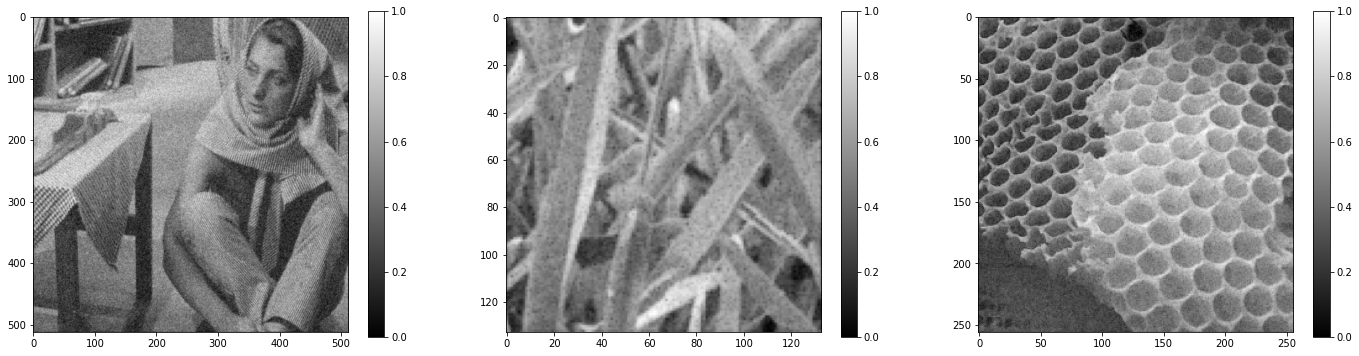

In [128]:
c_d = 1
c_i = 1.1
recovered_barbara = myBilateralFiltering(corrupted_barbara,c_d*sigma_d1,c_i*sigma_i1)
recovered_grass = myBilateralFiltering(corrupted_grass,c_d*sigma_d2,c_i*sigma_i2)
recovered_honey = myBilateralFiltering(corrupted_honey,c_d*sigma_d3,c_i*sigma_i3)
print("RMSD :",rmsd(barbara,recovered_barbara),rmsd(grass,recovered_grass),rmsd(honey,recovered_honey))
plt.figure(figsize=(24,6))
plt.subplot(131)
plt.imshow(recovered_barbara, cmap='gray')
plt.colorbar()
plt.subplot(132)
plt.imshow(recovered_grass, cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(recovered_honey, cmap='gray')
plt.colorbar()